In [1]:
# 确保此单元格是第一个运行的！
import jax
# 开启64位浮点数精度以提高数值稳定性
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.nn import tanh
from jax.example_libraries import optimizers
from jax.nn import tanh, softmax
import matplotlib.pyplot as plt
import itertools
from functools import partial
from tqdm import trange
import os
import pickle

# 全局随机种子
key = random.PRNGKey(0)

In [2]:
def exact_nls_two_dark_soliton_solution(t, x, params):
    """
    根据论文中矩阵行列式公式，计算N-分量NLS方程的二暗孤子精确解。
    """
    c = params['c']; a = params['a']; lambda1 = params['lambda1']; mu1 = params['mu1']; alpha1 = params['alpha1']; lambda2 = params['lambda2']; mu2 = params['mu2']; alpha2 = params['alpha2']; sigma = params['sigma']
    sum_c_sq = np.sum(c**2); N_components = len(c)
    q_solution = np.zeros((N_components,) + np.shape(x), dtype=np.complex128)
    X1 = mu1 * x + (lambda1 * mu1 + 0.5 * mu1**2 - 0.5 * lambda1**2) * t
    X2 = mu2 * x + (lambda2 * mu2 + 0.5 * mu2**2 - 0.5 * lambda2**2) * t
    conj_X1 = np.conj(X1); conj_X2 = np.conj(X2)
    mu1_I, mu2_I = np.imag(mu1), np.imag(mu2)
    conj_mu1, conj_mu2 = np.conj(mu1), np.conj(mu2)
    M11 = (2 * (np.exp(1j * (X1 - conj_X1)) + np.exp(2 * alpha1 * mu1_I))) / (mu1 - conj_mu1)
    M22 = (2 * (np.exp(1j * (X2 - conj_X2)) + np.exp(2 * alpha2 * mu2_I))) / (mu2 - conj_mu2)
    M12 = (2 * np.exp(1j * (X2 - conj_X1))) / ((lambda2 + mu2) - (lambda1 + conj_mu1))
    M21 = (2 * np.exp(1j * (X1 - conj_X2))) / ((lambda1 + mu1) - (lambda2 + conj_mu2))
    det_M = M11 * M22 - M12 * M21
    for i in range(N_components):
        theta_i = a[i] * x - (0.5 * a[i]**2 - sigma * sum_c_sq) * t
        beta1_i = 1 / (lambda1 + a[i] + mu1); beta2_i = 1 / (lambda2 + a[i] + mu2)
        Mi_11 = M11 - (2 * beta1_i / c[i]) * np.exp(1j * (X1 - conj_X1)); Mi_12 = M12 - (2 * beta2_i / c[i]) * np.exp(1j * (X2 - conj_X1))
        Mi_21 = M21 - (2 * beta1_i / c[i]) * np.exp(1j * (X1 - conj_X2)); Mi_22 = M22 - (2 * beta2_i / c[i]) * np.exp(1j * (X2 - conj_X2))
        det_Mi = Mi_11 * Mi_22 - Mi_12 * Mi_21
        q_solution = q_solution.at[i].set(c[i] * (det_Mi / det_M) * np.exp(1j * theta_i))
    return q_solution

def generate_data_points(params, t_domain, x_domain, N_ic, N_bc, N_res):
    """为单个初始条件生成训练数据点。"""
    t_min, t_max = t_domain; x_min, x_max = x_domain
    key = random.PRNGKey(42)

    x_ic = np.linspace(x_min, x_max, N_ic)
    t_ic = np.full_like(x_ic, t_min)
    q_ic = vmap(lambda t, x: exact_nls_two_dark_soliton_solution(t, x, params))(t_ic, x_ic)

    t_bc = np.linspace(t_min, t_max, N_bc)
    q_bc_min = vmap(lambda t: exact_nls_two_dark_soliton_solution(t, x_min, params))(t_bc)
    q_bc_max = vmap(lambda t: exact_nls_two_dark_soliton_solution(t, x_max, params))(t_bc)

    key_t, key_x = random.split(key)
    t_res = random.uniform(key_t, shape=(N_res, 1), minval=t_min, maxval=t_max)
    x_res = random.uniform(key_x, shape=(N_res, 1), minval=x_min, maxval=x_max)

    return {
        'IC': {'t': t_ic, 'x': x_ic, 'q': q_ic},
        'BC': {'t': t_bc, 'x_min': x_min, 'x_max': x_max, 'q_min': q_bc_min, 'q_max': q_bc_max},
        'RES': {'t': t_res.flatten(), 'x': x_res.flatten()}
    }

In [3]:
class DataGenerator:
    def __init__(self, u_data, y_data, q_data, batch_size=64):
        self.u_data = u_data
        self.y_data = y_data
        if np.iscomplexobj(q_data):
            self.q_data = np.concatenate([np.real(q_data), np.imag(q_data)], axis=-1)
        else:
            self.q_data = q_data
        self.batch_size = batch_size
        self.num_samples = u_data.shape[0]
        self.key = random.PRNGKey(1234)

    def __iter__(self):
        return self

    def __next__(self):
        self.key, subkey = random.split(self.key)
        indices = random.choice(subkey, self.num_samples, (self.batch_size,), replace=False)
        inputs = (self.u_data[indices], self.y_data[indices])
        outputs = self.q_data[indices]
        return {'inputs': inputs, 'outputs': outputs}

In [4]:
class ComplexDeepONet:
    def __init__(self, branch_layers, trunk_layers, N_components):
        self.branch_layers, self.trunk_layers, self.N_components = branch_layers, trunk_layers, N_components
        
        # 初始化网络
        self.branch_init, self.branch_apply = self.enhanced_MLP(branch_layers, activation=tanh)
        self.trunk_init, self.trunk_apply = self.enhanced_FF_MLP(trunk_layers, activation=tanh)
        
        # 参数初始化
        branch_key, trunk_key = random.split(random.PRNGKey(1234), 2)
        self.params = (self.branch_init(branch_key), self.trunk_init(trunk_key))
        
        # 修复：使用可用的学习率调度器
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(
            optimizers.exponential_decay(1e-3, decay_steps=10000, decay_rate=0.95)
        )
        self.opt_state = self.opt_init(self.params)
        self.itercount = itertools.count()
        
        # JIT编译
        self._loss = jit(self._calculate_total_loss)
        self._step = jit(self._update_step)
        
        # 训练监控
        self.loss_log, self.loss_ics_log, self.loss_bcs_log, self.loss_res_log = [], [], [], []
        self.iteration = 0
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.patience = 10000
        
        # 自适应重采样
        self.adaptive_points = []
        self.resampling_interval = 5000
        self.max_adaptive_points = 2000

    def enhanced_MLP(self, layers, activation=tanh):
        """增强的MLP with residual connections and layer normalization"""
        def init(rng_key):
            def init_layer(key, d_in, d_out):
                # Xavier/Glorot初始化
                stddev = np.sqrt(2.0 / (d_in + d_out))
                W = random.truncated_normal(key, -2, 2, (d_in, d_out)) * stddev
                b = np.zeros(d_out)
                # Layer normalization参数
                gamma = np.ones(d_out)
                beta = np.zeros(d_out)
                return W, b, gamma, beta
            
            key, *keys = random.split(rng_key, len(layers))
            return list(map(init_layer, keys, layers[:-1], layers[1:]))
        
        def layer_norm(x, gamma, beta, eps=1e-8):
            mean = np.mean(x, axis=-1, keepdims=True)
            var = np.var(x, axis=-1, keepdims=True)
            return gamma * (x - mean) / np.sqrt(var + eps) + beta
        
        def apply(params, inputs):
            x = inputs
            for i, (W, b, gamma, beta) in enumerate(params[:-1]):
                # 线性变换
                linear_out = np.dot(x, W) + b
                
                # Layer normalization
                normalized = layer_norm(linear_out, gamma, beta)
                
                # 激活函数
                activated = activation(normalized)
                
                # 残差连接 (如果维度匹配)
                if x.shape[-1] == activated.shape[-1] and i > 0:
                    x = x + activated
                else:
                    x = activated
            
            # 输出层
            W, b, _, _ = params[-1]
            return np.dot(x, W) + b
        
        return init, apply

    def enhanced_FF_MLP(self, layers, activation=tanh, B_scale=10.0):
        """增强的傅里叶特征MLP with multi-scale encoding"""
        key = random.PRNGKey(0)
        input_dim = layers[0]
        
        # 修复：确保傅里叶特征维度正确匹配
        total_fourier_features = layers[1]
        fourier_dim = total_fourier_features // 6  # 3个尺度，每个尺度sin+cos
        
        # 多尺度傅里叶特征
        scales = [1.0, 5.0, 25.0]
        B_matrices = []
        for scale in scales:
            B = random.normal(key, (input_dim, fourier_dim)) * B_scale * scale
            B_matrices.append(B)
        
        # 确保输出维度正确
        actual_output_dim = len(scales) * fourier_dim * 2  # 每个尺度产生sin+cos
        
        # 调整后续层的输入维度
        adjusted_layers = [actual_output_dim] + layers[2:]
        init_mlp, apply_mlp = self.enhanced_MLP(adjusted_layers, activation)
        
        def multi_scale_fourier_encoding(x):
            features = []
            for B in B_matrices:
                x_proj = np.dot(x, B)
                features.append(np.sin(x_proj))
                features.append(np.cos(x_proj))
            return np.hstack(features)
        
        def init(rng_key):
            return init_mlp(rng_key)
        
        def apply(params, inputs):
            encoded_inputs = multi_scale_fourier_encoding(inputs)
            return apply_mlp(params, encoded_inputs)
        
        return init, apply

    def operator_net(self, params, u_initial, y_coords):
        """简化的算子网络"""
        branch_params, trunk_params = params
        branch_output = self.branch_apply(branch_params, u_initial)
        trunk_output = self.trunk_apply(trunk_params, y_coords)
        
        p = self.trunk_layers[-1]
        batch_size = u_initial.shape[0]
        
        # 重塑branch输出
        branch_reshaped = branch_output.reshape(batch_size, self.N_components * 2, p)
        trunk_expanded = trunk_output[:, None, :]
        
        # 简单的点积操作
        return np.sum(branch_reshaped * trunk_expanded, axis=2)

    def residual_net(self, params, u_initial, t, x):
        """改进的物理残差计算"""
        def q_func(t, x):
            output = self.operator_net(params, u_initial[None, :], np.array([[t, x]]))[0]
            return output[:self.N_components] + 1j * output[self.N_components:]
        
        # 计算导数
        q_t = jax.jacfwd(q_func, argnums=0)(t, x)
        q_xx = jax.jacfwd(jax.jacfwd(q_func, argnums=1), argnums=1)(t, x)
        q_val = q_func(t, x)
        
        # 修正的NLS方程: i*q_t + 0.5*q_xx - |q|^2*q = 0 (暗孤子)
        nonlinear_term = np.sum(np.abs(q_val)**2) * q_val
        residual = 1j * q_t + 0.5 * q_xx - nonlinear_term
        
        return np.sum(np.abs(residual)**2)

    def adaptive_loss_weights(self, ic_loss, bc_loss, res_loss):
        """自适应损失权重调整"""
        # 基于损失大小的自适应权重
        total = ic_loss + bc_loss + res_loss + 1e-8
        
        # 课程学习权重
        progress = min(1.0, self.iteration / 100000)
        
        if progress < 0.3:
            # 早期：重点学习初始条件
            w_ic = 100.0 * (1.0 + res_loss / total)
            w_bc = 10.0
            w_res = 1.0
        elif progress < 0.7:
            # 中期：平衡学习
            w_ic = 50.0
            w_bc = 10.0 * (1.0 + ic_loss / total)
            w_res = 100.0
        else:
            # 后期：重点物理约束
            w_ic = 10.0
            w_bc = 1.0
            w_res = 1000.0 * (1.0 + (ic_loss + bc_loss) / total)
        
        return w_ic, w_bc, w_res

    def loss_ics(self, params, batch):
        pred = self.operator_net(params, *batch['inputs'])
        target = batch['outputs']
        
        # L2 + L1正则化
        l2_loss = np.mean((target - pred)**2)
        l1_loss = np.mean(np.abs(target - pred))
        
        return l2_loss + 0.1 * l1_loss

    def loss_bcs(self, params, batch):
        pred = self.operator_net(params, *batch['inputs'])
        target = batch['outputs']
        
        # 边界条件的强制约束
        l2_loss = np.mean((target - pred)**2)
        return l2_loss

    def loss_res(self, params, batch):
        u_initial, y_coords = batch['inputs']
        
        # 基础物理残差
        base_residual = np.mean(vmap(lambda u, y: self.residual_net(params, u, y[0], y[1]))(u_initial, y_coords))
        
        # 自适应点的额外残差
        if len(self.adaptive_points) > 0:
            adaptive_coords = np.array(self.adaptive_points)
            u_adaptive = np.tile(u_initial[0], (len(adaptive_coords), 1))
            adaptive_residual = np.mean(vmap(lambda u, y: self.residual_net(params, u, y[0], y[1]))(u_adaptive, adaptive_coords))
            return base_residual + 0.5 * adaptive_residual
        
        return base_residual

    def _calculate_total_loss(self, params, ic_batch, bc_batch, res_batch):
        loss_i = self.loss_ics(params, ic_batch)
        loss_b = self.loss_bcs(params, bc_batch)
        loss_r = self.loss_res(params, res_batch)
        
        # 自适应权重
        w_ic, w_bc, w_res = self.adaptive_loss_weights(loss_i, loss_b, loss_r)
        
        total_loss = w_ic * loss_i + w_bc * loss_b + w_res * loss_r
        
        # L2正则化
        l2_reg = 0.0
        branch_params, trunk_params = params
        for W, b, gamma, beta in branch_params:
            l2_reg += np.sum(W**2)
        for W, b, gamma, beta in trunk_params:
            l2_reg += np.sum(W**2)
        
        return total_loss + 1e-6 * l2_reg

    def _update_step(self, i, opt_state, ic_batch, bc_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self._calculate_total_loss)(params, ic_batch, bc_batch, res_batch)
        
        # 梯度裁剪 - 使用JAX条件函数
        g_norm = np.sqrt(sum(np.sum(np.square(g_layer)) for g_layer in jax.tree_util.tree_leaves(g)))
        g = jax.lax.cond(
            g_norm > 1.0,
            lambda g: jax.tree_util.tree_map(lambda x: x / g_norm, g),
            lambda g: g,
            g
        )
        
        return self.opt_update(i, g, opt_state)
        

    def simple_adaptive_resampling(self, params, u_initial, t_domain, x_domain, n_new_points=500):
        """简化的自适应重采样"""
        key = random.PRNGKey(int(self.iteration) % 2**32)
        t_key, x_key = random.split(key)
        
        # 80%在核心区域，20%在扩展区域
        n_core = int(0.8 * n_new_points)
        n_extended = n_new_points - n_core
        
        t_core = random.uniform(t_key, (n_core,), minval=t_domain[0], maxval=t_domain[1])
        x_core = random.uniform(x_key, (n_core,), minval=-2.0, maxval=2.0)
        
        t_ext = random.uniform(t_key, (n_extended,), minval=t_domain[0], maxval=t_domain[1])
        x_ext = random.uniform(x_key, (n_extended,), minval=t_domain[0], maxval=t_domain[1])
        
        t_new = np.concatenate([t_core, t_ext])
        x_new = np.concatenate([x_core, x_ext])
        
        return np.column_stack([t_new, x_new])

    def train(self, ic_dataset, bc_dataset, res_dataset, nIter=10000, t_domain=None, x_domain=None):
        ic_iter, bc_iter, res_iter = iter(ic_dataset), iter(bc_dataset), iter(res_dataset)
        pbar = trange(nIter)
        
        for it in pbar:
            self.iteration = it
            ic_batch, bc_batch, res_batch = next(ic_iter), next(bc_iter), next(res_iter)
            
            # 自适应重采样
            if (it > 0 and it % self.resampling_interval == 0 and 
                len(self.adaptive_points) < self.max_adaptive_points and 
                t_domain is not None and x_domain is not None):
                
                try:
                    u_initial = ic_batch['inputs'][0][0]  # 获取一个初始条件
                    new_points = self.simple_adaptive_resampling(
                        self.params, u_initial, t_domain, x_domain, 300
                    )
                    self.adaptive_points.extend(new_points.tolist())
                    print(f"\n自适应重采样: 添加了 {len(new_points)} 个点")
                except Exception as e:
                    print(f"重采样失败: {e}")
            
            # 更新参数
            self.opt_state = self._step(next(self.itercount), self.opt_state, ic_batch, bc_batch, res_batch)
            
            # 监控和记录
            if it % 100 == 0:
                self.params = self.get_params(self.opt_state)
                loss_val = self._loss(self.params, ic_batch, bc_batch, res_batch)
                loss_i = self.loss_ics(self.params, ic_batch)
                loss_b = self.loss_bcs(self.params, bc_batch)
                loss_r = self.loss_res(self.params, res_batch)
                
                # 早停检查
                if loss_val < self.best_loss:
                    self.best_loss = loss_val
                    self.patience_counter = 0
                else:
                    self.patience_counter += 100
                
                self.loss_log.append(loss_val)
                self.loss_ics_log.append(loss_i)
                self.loss_bcs_log.append(loss_b)
                self.loss_res_log.append(loss_r)
                
                # 详细分析
                if it % 1000 == 0:
                    w_ic, w_bc, w_res = self.adaptive_loss_weights(loss_i, loss_b, loss_r)
                    print(f"\n迭代 {it}: 权重 IC:{w_ic:.1f}, BC:{w_bc:.1f}, Res:{w_res:.1f}")
                    print(f"自适应点数: {len(self.adaptive_points)}")
                
                pbar.set_postfix({
                    'Loss': f'{loss_val:.2e}', 
                    'IC': f'{loss_i:.2e}', 
                    'BC': f'{loss_b:.2e}', 
                    'Res': f'{loss_r:.2e}',
                    'Best': f'{self.best_loss:.2e}'
                })
                
                # 早停
                if self.patience_counter >= self.patience:
                    print(f"\n早停触发，在迭代 {it}")
                    break

    def predict_q(self, params, u_initial, y_coords):
        """预测复数解"""
        output = self.operator_net(params, u_initial, y_coords)
        return output[:, :self.N_components] + 1j * output[:, self.N_components:]

    def evaluate_model(self, params, test_data, exact_solution_func):
        """模型评估"""
        u_test, y_test = test_data
        q_pred = self.predict_q(params, u_test, y_test)
        
        # 计算精确解
        q_exact = vmap(lambda y: exact_solution_func(y[0], y[1]))(y_test)
        
        # 计算误差
        l2_error = np.linalg.norm(q_exact - q_pred) / np.linalg.norm(q_exact)
        linf_error = np.max(np.abs(q_exact - q_pred))
        
        return {
            'l2_relative_error': float(l2_error),
            'linf_error': float(linf_error),
            'predictions': q_pred,
            'exact': q_exact
        }

In [5]:
# --- 1. 定义三分量参数和域 ---
N_components = 3
soliton_params = {
    'c': np.array([1.0, 1.0, 1.0]),
    'a': np.array([1.0, -1.0, 0.0]),
    'lambda1': 0.0,
    'mu1': (np.sqrt(2)/2) * (1+1j),
    'alpha1': 0.0,
    'lambda2': 0.0,
    'mu2': -(np.sqrt(2)/2) * (1+1j),
    'alpha2': 0.0,
    'sigma': -1.0  # 暗孤子对应的 sigma
}
t_domain = [-4.0, 4.0]
x_domain = [-8.0, 8.0]
N_ic_train, N_bc_train, N_res_train = 512, 256, 10000

# --- 2. 【修正】统一并修正网络结构参数 ---
branch_input_dim = N_ic_train * N_components * 2  # 512 * 3 * 2 = 3072
p = 100
branch_output_dim = N_components * 2 * p  # 3 * 2 * 100 = 600
branch_layers = [branch_input_dim, 512, 512, branch_output_dim]
trunk_layers = [2, 128, 128, 128, p]

# --- 3. 生成并准备数据集 ---
train_data_points = generate_data_points(soliton_params, t_domain, x_domain, N_ic_train, N_bc_train, N_res_train)

# 准备 Branch Net 的输入 u_initial_train
u_initial_real = np.real(train_data_points['IC']['q']).flatten()
u_initial_imag = np.imag(train_data_points['IC']['q']).flatten()
u_initial_train = np.hstack([u_initial_real, u_initial_imag])

# IC 数据集
ic_u = np.tile(u_initial_train, (N_ic_train, 1))
ic_y = np.hstack([train_data_points['IC']['t'][:, None], train_data_points['IC']['x'][:, None]])
ic_q = train_data_points['IC']['q']
ic_dataset = DataGenerator(ic_u, ic_y, ic_q, batch_size=64)

# BC 数据集
bc_t_all = np.tile(train_data_points['BC']['t'], 2)
bc_x_all = np.hstack([np.full(N_bc_train, train_data_points['BC']['x_min']), np.full(N_bc_train, train_data_points['BC']['x_max'])])
bc_y = np.vstack([bc_t_all, bc_x_all]).T
bc_q = np.vstack([train_data_points['BC']['q_min'], train_data_points['BC']['q_max']])
bc_u = np.tile(u_initial_train, (bc_y.shape[0], 1))
bc_dataset = DataGenerator(bc_u, bc_y, bc_q, batch_size=64)

# RES 数据集
res_u = np.tile(u_initial_train, (N_res_train, 1))
res_y = np.hstack([train_data_points['RES']['t'][:, None], train_data_points['RES']['x'][:, None]])
res_q = np.zeros((N_res_train, N_components * 2))
res_dataset = DataGenerator(res_u, res_y, res_q, batch_size=128)

print("三分量、固定参数(吸引型)数据集已准备就绪。")
print(f"Branch Net 输入维度: {branch_input_dim}, u_initial_train 实际维度: {u_initial_train.shape[0]}")

三分量、固定参数(吸引型)数据集已准备就绪。
Branch Net 输入维度: 3072, u_initial_train 实际维度: 3072


In [6]:
# 实例化模型
model = ComplexDeepONet(branch_layers, trunk_layers, N_components)

print("\n开始训练...")
model.train(ic_dataset, bc_dataset, res_dataset, nIter=200000, 
           t_domain=t_domain, x_domain=x_domain)
print("训练完成。")

# 保存模型参数
params_save_path = "attractive_3comp_model_params.pkl"
with open(params_save_path, 'wb') as f:
    pickle.dump(model.params, f)
print(f"模型参数已保存到: {params_save_path}")


开始训练...


  0%|          | 6/200000 [00:04<33:16:47,  1.67it/s, Loss=3.56e+12, IC=9.61e+01, BC=1.04e+02, Res=3.56e+12, Best=3.56e+12] 


迭代 0: 权重 IC:200.0, BC:10.0, Res:1.0
自适应点数: 0


  1%|          | 1008/200000 [00:36<1:49:53, 30.18it/s, Loss=1.12e+02, IC=3.83e-01, BC=5.85e-01, Res=3.08e+01, Best=1.12e+02]


迭代 1000: 权重 IC:197.0, BC:10.0, Res:1.0
自适应点数: 0


  1%|          | 2006/200000 [01:08<1:54:06, 28.92it/s, Loss=4.75e+01, IC=3.90e-01, BC=5.66e-01, Res=7.21e-02, Best=4.75e+01]


迭代 2000: 权重 IC:107.0, BC:10.0, Res:1.0
自适应点数: 0


  2%|▏         | 3004/200000 [01:41<2:05:42, 26.12it/s, Loss=4.49e+01, IC=3.90e-01, BC=5.49e-01, Res=9.77e-03, Best=4.31e+01]


迭代 3000: 权重 IC:101.0, BC:10.0, Res:1.0
自适应点数: 0


  2%|▏         | 4005/200000 [02:15<1:54:36, 28.50it/s, Loss=4.58e+01, IC=3.98e-01, BC=5.28e-01, Res=1.53e-02, Best=4.24e+01]


迭代 4000: 权重 IC:101.6, BC:10.0, Res:1.0
自适应点数: 0


  2%|▏         | 4998/200000 [02:47<1:46:29, 30.52it/s, Loss=4.48e+01, IC=3.87e-01, BC=5.52e-01, Res=1.56e-02, Best=4.24e+01]


自适应重采样: 添加了 300 个点


  3%|▎         | 5006/200000 [02:49<7:27:13,  7.27it/s, Loss=4.40e+01, IC=3.80e-01, BC=5.21e-01, Res=3.10e-02, Best=4.24e+01] 


迭代 5000: 权重 IC:103.3, BC:10.0, Res:1.0
自适应点数: 300


  3%|▎         | 6007/200000 [03:23<1:59:45, 27.00it/s, Loss=4.49e+01, IC=3.84e-01, BC=5.78e-01, Res=2.76e-02, Best=4.24e+01]


迭代 6000: 权重 IC:102.8, BC:10.0, Res:1.0
自适应点数: 300


  4%|▎         | 7005/200000 [03:57<2:19:08, 23.12it/s, Loss=4.44e+01, IC=3.83e-01, BC=5.45e-01, Res=2.25e-02, Best=4.24e+01]


迭代 7000: 权重 IC:102.4, BC:10.0, Res:1.0
自适应点数: 300


  4%|▍         | 8007/200000 [04:30<2:04:30, 25.70it/s, Loss=4.46e+01, IC=3.83e-01, BC=5.61e-01, Res=2.32e-02, Best=4.24e+01]


迭代 8000: 权重 IC:102.4, BC:10.0, Res:1.0
自适应点数: 300


  5%|▍         | 9008/200000 [05:04<1:58:06, 26.95it/s, Loss=4.47e+01, IC=3.86e-01, BC=5.31e-01, Res=2.68e-02, Best=4.24e+01]


迭代 9000: 权重 IC:102.8, BC:10.0, Res:1.0
自适应点数: 300


  5%|▌         | 10000/200000 [05:36<1:37:37, 32.44it/s, Loss=4.65e+01, IC=4.05e-01, BC=5.52e-01, Res=2.17e-02, Best=4.24e+01]


自适应重采样: 添加了 300 个点


  5%|▌         | 10008/200000 [05:38<6:53:05,  7.67it/s, Loss=4.59e+01, IC=3.97e-01, BC=5.56e-01, Res=2.21e-02, Best=4.24e+01]


迭代 10000: 权重 IC:102.3, BC:10.0, Res:1.0
自适应点数: 600


  6%|▌         | 11006/200000 [06:11<1:55:58, 27.16it/s, Loss=4.42e+01, IC=3.79e-01, BC=5.72e-01, Res=2.61e-02, Best=4.24e+01]


迭代 11000: 权重 IC:102.7, BC:10.0, Res:1.0
自适应点数: 600


  6%|▌         | 12006/200000 [06:44<1:58:22, 26.47it/s, Loss=4.52e+01, IC=3.91e-01, BC=5.60e-01, Res=2.66e-02, Best=4.24e+01]


迭代 12000: 权重 IC:102.7, BC:10.0, Res:1.0
自适应点数: 600


  7%|▋         | 13006/200000 [07:17<2:00:02, 25.96it/s, Loss=4.61e+01, IC=4.02e-01, BC=5.48e-01, Res=2.84e-02, Best=4.24e+01]


迭代 13000: 权重 IC:102.9, BC:10.0, Res:1.0
自适应点数: 600


  7%|▋         | 13100/200000 [07:20<1:44:42, 29.75it/s, Loss=4.37e+01, IC=3.78e-01, BC=5.41e-01, Res=3.65e-02, Best=4.24e+01]


早停触发，在迭代 13100
训练完成。
模型参数已保存到: attractive_3comp_model_params.pkl


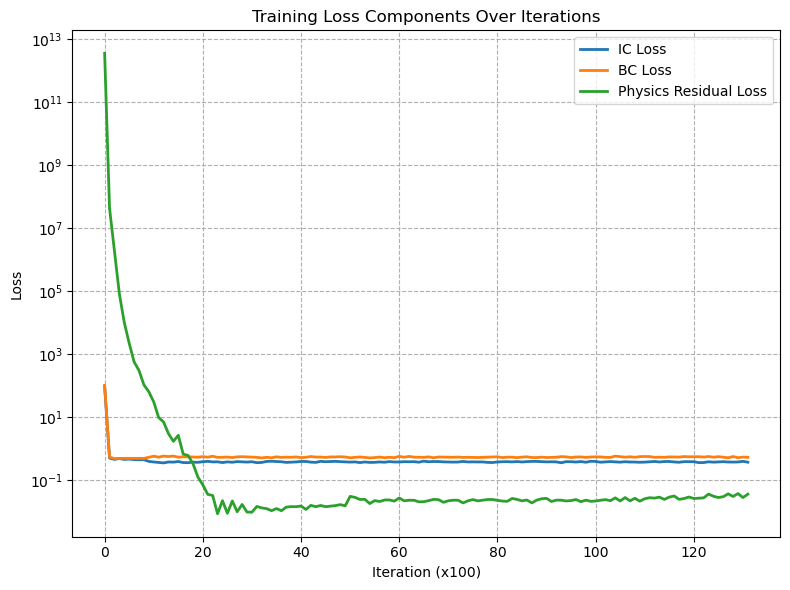

In [9]:
# --- Visualizing Training Loss ---

plt.figure(figsize=(8, 6))
plt.plot(model.loss_ics_log, label='IC Loss', lw=2)
plt.plot(model.loss_bcs_log, label='BC Loss', lw=2)
plt.plot(model.loss_res_log, label='Physics Residual Loss', lw=2)

plt.xlabel('Iteration (x100)')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss Components Over Iterations')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

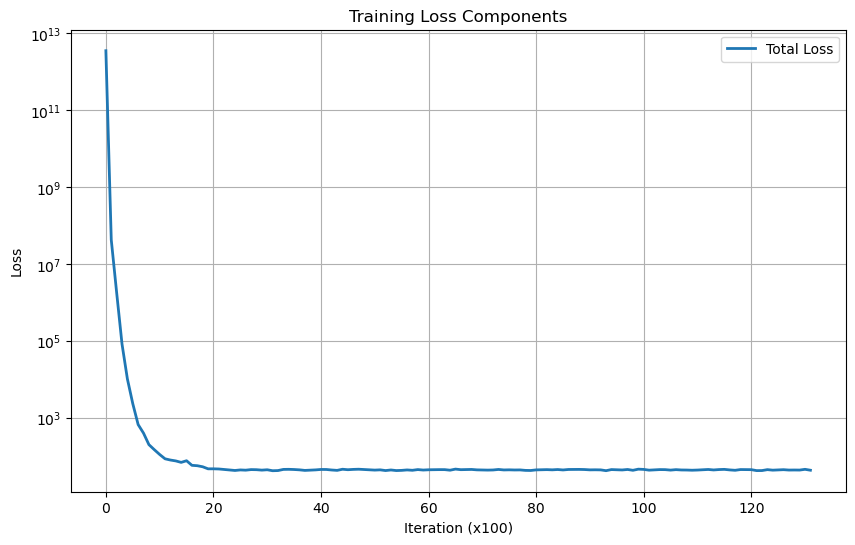


--- 正在生成一个固定参数的例子用于可视化 ---


ValueError: too many values to unpack (expected 2)

In [8]:
# --- 1. 可视化损失 ---
plt.figure(figsize=(10, 6))
plt.plot(model.loss_log, label='Total Loss', lw=2)
# ... (其他损失曲线绘制) ...
plt.xlabel('Iteration (x100)'); plt.ylabel('Loss'); plt.yscale('log')
plt.title('Training Loss Components'); plt.legend(); plt.grid(True); plt.show()

# --- 2. 可视化一个特定例子 ---
print("\n--- 正在生成一个固定参数的例子用于可视化 ---")
# 使用一组固定的、安全的参数来测试
key, subkey = random.split(key)
vis_params, _ = soliton_params
print("用于可视化的参数:", vis_params)

# 准备测试数据
vis_data_points = data_generator.generate_data_points(vis_params)
u_initial_vis_real = np.real(vis_data_points['IC']['q']).flatten()
u_initial_vis_imag = np.imag(vis_data_points['IC']['q']).flatten()
u_initial_vis = np.hstack([u_initial_vis_real, u_initial_vis_imag])

T, X = np.meshgrid(np.linspace(t_domain[0], t_domain[1], 101),
                   np.linspace(x_domain[0], x_domain[1], 401))
y_coords_test = np.hstack([T.flatten()[:, None], X.flatten()[:, None]])
u_initial_test = np.tile(u_initial_vis, (y_coords_test.shape[0], 1))

# 模型预测
trained_params = model.get_params(model.opt_state)
q_pred = model.predict_q(trained_params, u_initial_test, y_coords_test)
q_pred_grid = q_pred.reshape(T.shape[0], T.shape[1], N_components)

# 精确解
q_exact = vmap(exact_nls_two_dark_soliton_solution, (0, 0, None))(y_coords_test[:, 0], y_coords_test[:, 1], vis_params)
q_exact_grid = q_exact.reshape(T.shape[0], T.shape[1], N_components)

# ... (复制上一版完整的绘图代码) ...
# 绘制热图
for i in range(N_components):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Component q_{i+1}', fontsize=16)
    im1 = axes[0].imshow(np.abs(q_exact_grid[:, :, i]).T, extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]], origin='lower', aspect='auto', cmap='viridis')
    axes[0].set_title(f'Exact Solution |q_{i+1}|')
    fig.colorbar(im1, ax=axes[0])
    im2 = axes[1].imshow(np.abs(q_pred_grid[:, :, i]).T, extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]], origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_title(f'Predicted Solution |q_{i+1}|')
    fig.colorbar(im2, ax=axes[1])
    im3 = axes[2].imshow(np.abs(np.abs(q_exact_grid[:, :, i]) - np.abs(q_pred_grid[:, :, i])).T, extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]], origin='lower', aspect='auto', cmap='viridis')
    axes[2].set_title(f'Absolute Error')
    fig.colorbar(im3, ax=axes[2])
    for ax in axes: ax.set_xlabel('Time t'); ax.set_ylabel('Space x')
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

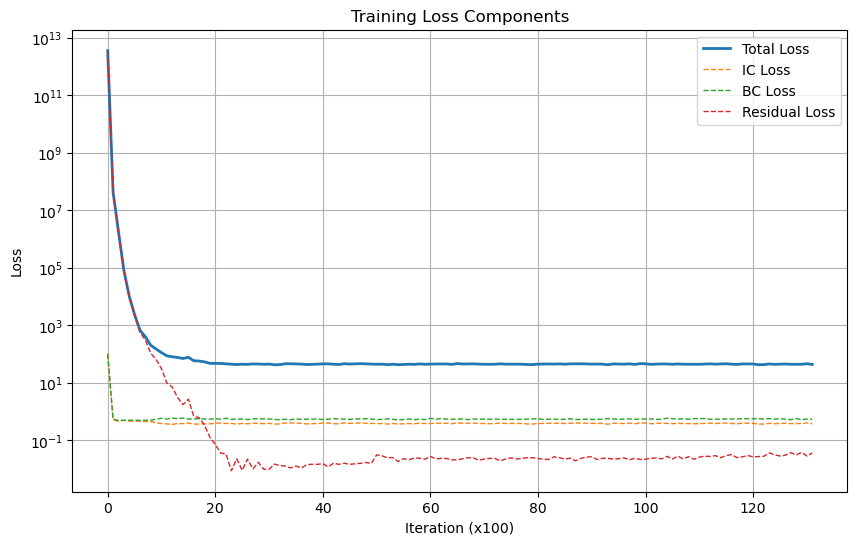

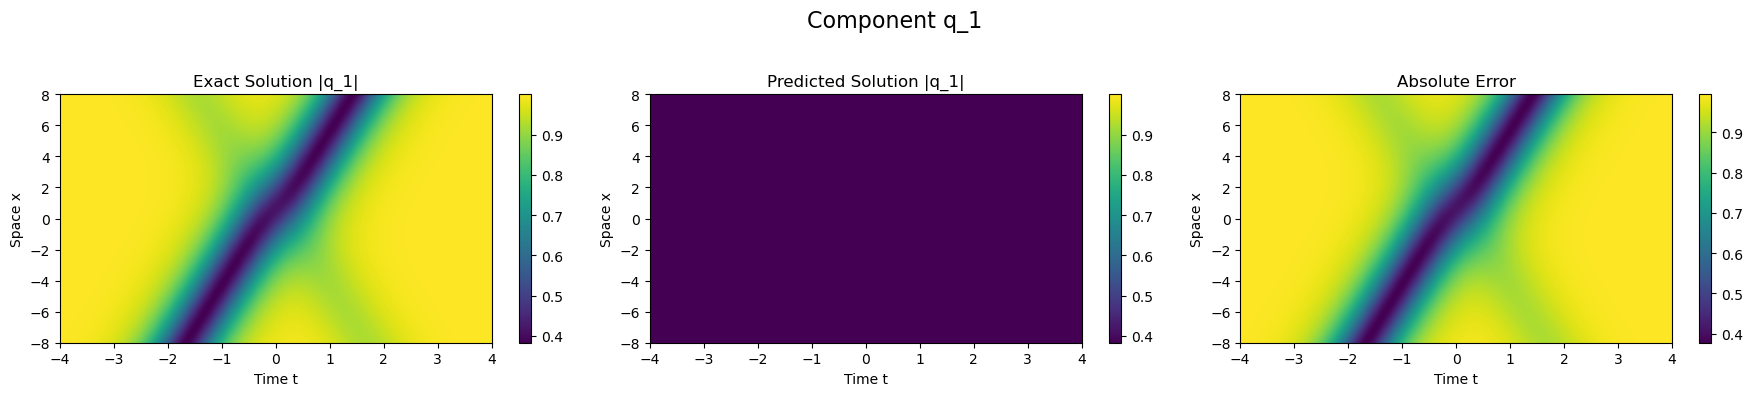

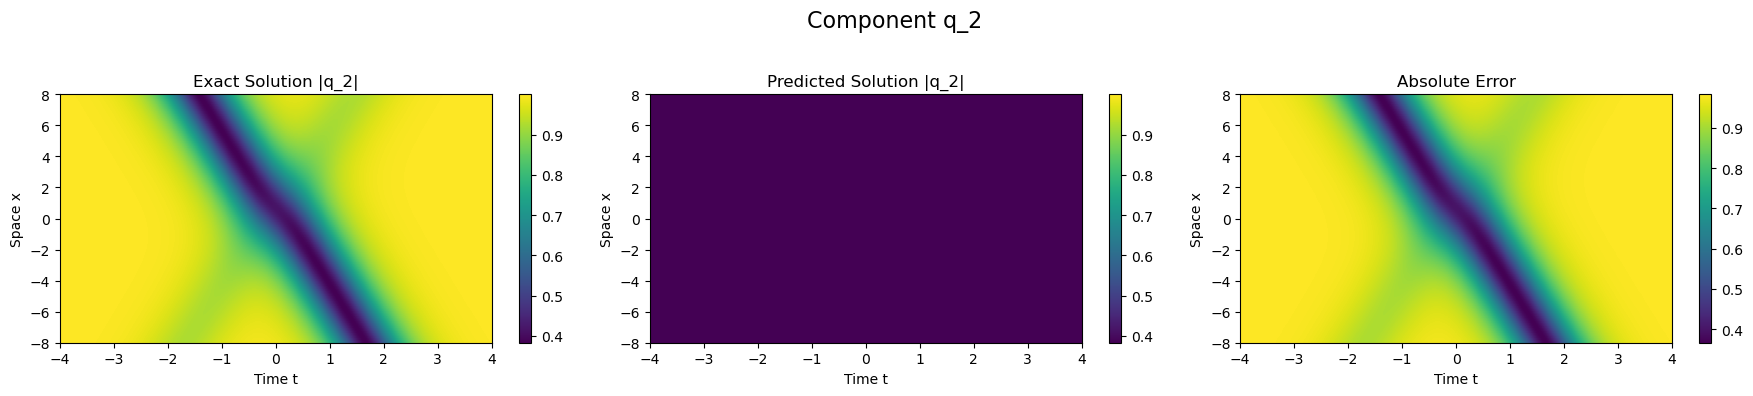

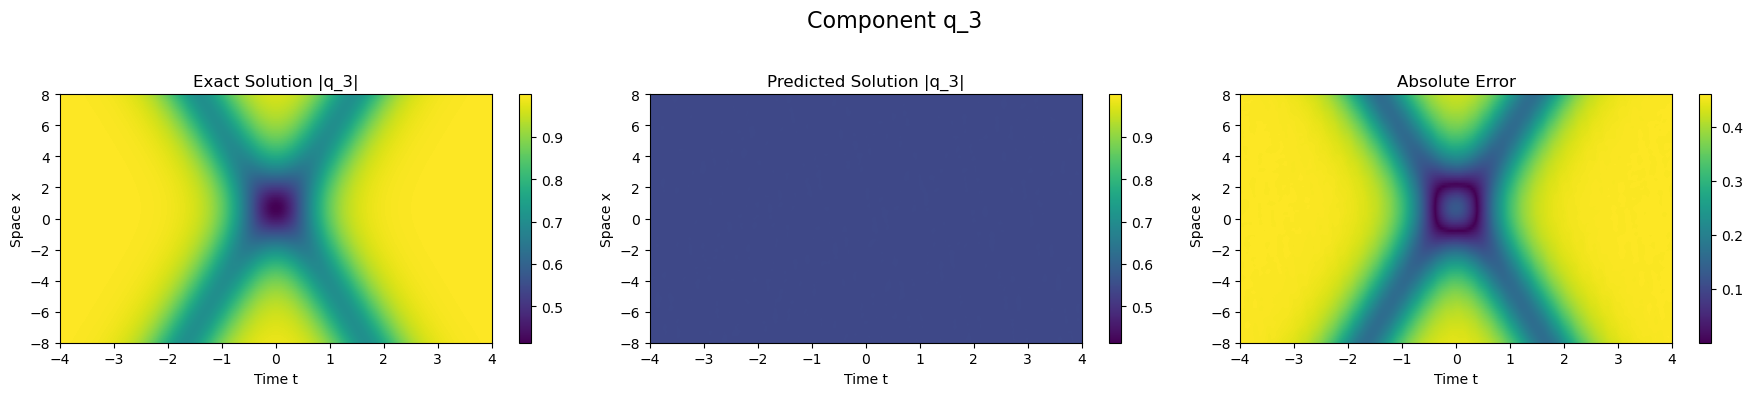

In [10]:
# --- 1. 可视化损失 ---
plt.figure(figsize=(10, 6))
plt.plot(model.loss_log, label='Total Loss', lw=2)
plt.plot(model.loss_ics_log, label='IC Loss', lw=1, linestyle='--')
plt.plot(model.loss_bcs_log, label='BC Loss', lw=1, linestyle='--')
plt.plot(model.loss_res_log, label='Residual Loss', lw=1, linestyle='--')
plt.xlabel('Iteration (x100)'); plt.ylabel('Loss'); plt.yscale('log')
plt.title('Training Loss Components'); plt.legend(); plt.grid(True); plt.show()

# --- 2. 可视化解 ---
trained_params = model.get_params(model.opt_state)
T, X = np.meshgrid(np.linspace(t_domain[0], t_domain[1], 101),
                   np.linspace(x_domain[0], x_domain[1], 401))
y_coords_test = np.hstack([T.flatten()[:, None], X.flatten()[:, None]])
u_initial_test = np.tile(u_initial_train, (y_coords_test.shape[0], 1))

q_pred = model.predict_q(trained_params, u_initial_test, y_coords_test)
q_pred_grid = q_pred.reshape(T.shape[0], T.shape[1], N_components)

q_exact = vmap(exact_nls_two_dark_soliton_solution, (0, 0, None))(y_coords_test[:, 0], y_coords_test[:, 1], soliton_params)
q_exact_grid = q_exact.reshape(T.shape[0], T.shape[1], N_components)

# 绘制热图
for i in range(N_components):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Component q_{i+1}', fontsize=16)
    v_min = np.min(np.abs(q_exact_grid[:, :, i])); v_max = np.max(np.abs(q_exact_grid[:, :, i]))
    im1 = axes[0].imshow(np.abs(q_exact_grid[:, :, i]).T, extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]], origin='lower', aspect='auto', cmap='viridis', vmin=v_min, vmax=v_max)
    axes[0].set_title(f'Exact Solution |q_{i+1}|'); fig.colorbar(im1, ax=axes[0])
    im2 = axes[1].imshow(np.abs(q_pred_grid[:, :, i]).T, extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]], origin='lower', aspect='auto', cmap='viridis', vmin=v_min, vmax=v_max)
    axes[1].set_title(f'Predicted Solution |q_{i+1}|'); fig.colorbar(im2, ax=axes[1])
    im3 = axes[2].imshow(np.abs(np.abs(q_exact_grid[:, :, i]) - np.abs(q_pred_grid[:, :, i])).T, extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]], origin='lower', aspect='auto', cmap='viridis')
    axes[2].set_title(f'Absolute Error'); fig.colorbar(im3, ax=axes[2])
    for ax in axes: ax.set_xlabel('Time t'); ax.set_ylabel('Space x')
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()